# Maximum Entropy Imputation

In [134]:
import numpy as np
# import scipy.stats as stats
# import scipy.optimize as opt
# import scipy.io
# import scipy.signal as signal
# import scipy.interpolate as interp
import matplotlib.pyplot as plt
import matplotlib.style as style; style.use('ggplot')

from util.gmm import EXAMPLE
from util.expectiles import expectile

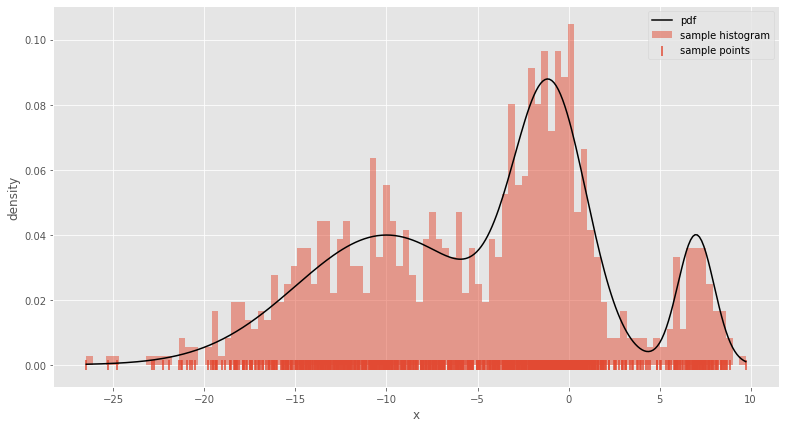

In [135]:
SAMPLE, GMM_X, GMM_Y = EXAMPLE(1000)

## Maximum entropy imputation

The maximum entropy principle says that if all you have are some observed statistics of an unknown distribution, then the best you can do when recovering the original distribution is to find the distribution with the maximum entropy amongst all distributions with your property. This is the distribution which is 'most similar' to the uniform distribution, whilst still satisfying your observations. It is 'maximally non-committal' beyond the information contained in your observations, so encodes the fewest assumptions.

In our case, our observations are a set of $K$ expectile values (for various asymmetries), $\epsilon_{\tau_i} \doteq \epsilon_i$ for $i=1, 2, \ldots, K$. That is, we require of our distribution $\eta$ that:

$$
-\frac{1}{2} ER'(\epsilon_i; \eta, \tau_i)
=
0
\qquad (i = 1, 2, ..., K)
$$

where
$
ER'(\epsilon_i; \eta, \tau)
=
\frac{\partial}{\partial \epsilon}
ER(\epsilon;\eta,\tau)
|_{\epsilon=\epsilon_i}
$.

Thus, maximum entropy inference suggests that we should solve the following optimisation problem to find $\eta$:

\begin{align*}
\eta
&=
\underset{\text{$\eta$ is a distribution}}{\text{arg max}}~ H[\eta]
\\
\text{s.t.} ~0 &= -\frac{1}{2} ER'(\epsilon_i; \eta, \tau_i) \qquad (i = 1, 2, ..., K)
\end{align*}

To solve this optimisation problem, we can optimise a Lagrangian functional in terms of the pdf of $\eta$, $f$ (with a normalisation constraint).

\begin{align*}
\mathcal{L}[f, \lambda_0, \vec{\lambda} = (\lambda_1, \ldots, \lambda_K)]
&=
-\int_z f(z) \ln f(z) dz
+ \lambda_0 \left( \int_z f(z) dz - 1\right)
+ \sum_{i=1}^K \lambda_i \int_z f(z) (z - \epsilon_i) \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i} dz
\\
\rightarrow
\frac{\delta\mathcal{L}}{\delta f}
&=
- \frac{\partial}{\partial f(z)} f(z) \ln f(z)
+ \lambda_0  \frac{\partial}{\partial f(z)} f(z)
+ \sum_{i=1}^K \lambda_i \frac{\partial}{\partial f(z)} f(z) (z - \epsilon_i) \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i}
\\
&= 
- \ln f(z) - 1
+ \lambda_0
+ \sum_{i=1}^K \lambda_i (z - \epsilon_i) \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i}
\\
&\overset{!}{=} 0
\\
\rightarrow f(z)
&=\exp(\lambda_0 - 1) \exp\left(\sum_{i=1}^K \lambda_i (z - \epsilon_i) \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i}\right)
\\
&=\frac{1}{Z}\exp\left(\sum_{i=1}^K \lambda_i (z - \epsilon_i) \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i}\right)
~\text{where}~
Z = \int_z\exp\left(\sum_{i=1}^K \lambda_i (z - \epsilon_i) \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i}\right)dz
\end{align*}

To understand this result, we must inspect the exponent $\sum_{i=1}^K \lambda_i (z - \epsilon_i) \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i}$. It appears to be a sum of pieceswise linear functions of $z$ (and so is itself a piecewise linear function of $z$). In fact, we can show this:

\begin{align*}
&
\sum_{i=1}^K \lambda_i (z - \epsilon_i) \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i}
\\
&=
\sum_{i=1}^K \lambda_i \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i} z
-
\sum_{i=1}^K \lambda_i \epsilon_i \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i}
\\
&=
\left(
  \sum_{i:\epsilon_i \lt  z} \tau_i     \lambda_i
+ \sum_{i:\epsilon_i \geq z} (1-\tau_i) \lambda_i
\right)
z
-
\left(
  \sum_{i:\epsilon_i \lt  z} \tau_i     \lambda_i \epsilon_i
+ \sum_{i:\epsilon_i \geq z} (1-\tau_i) \lambda_i \epsilon_i
\right)
\\
&\doteq
A(z) z + B(z)
\end{align*}

Noting that $A(z)$ and $B(z)$ are flat except where $z\neq \epsilon_i$ for some $i$, we see that this is indeed a piecewise linear function.

What does it look like, for different $\vec{\lambda}$?

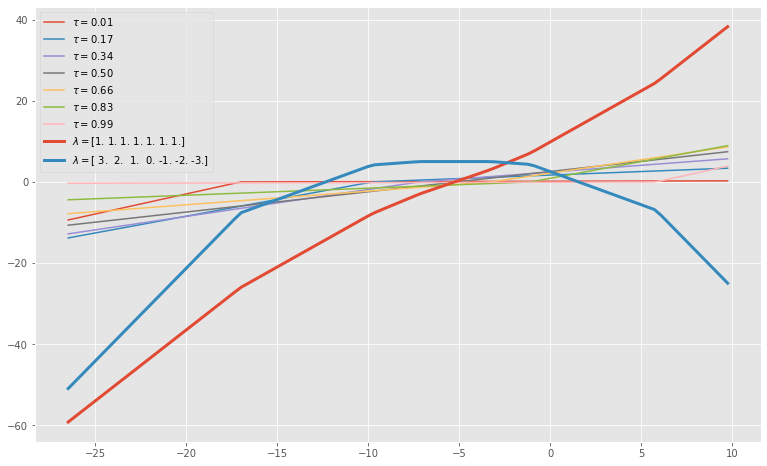

In [3]:
def maxent_exponent_components(taus, sample):
    epss = expectile(sample, taus) 
    z = np.linspace(sample.min(), sample.max(), 100)
    gte = z[:, np.newaxis]>epss
    R = (z[:, np.newaxis]-epss)*(1-gte-taus+2*taus*gte)
    return z, R
def maxent_exponent(R, lams):
    return np.sum(lams*R, axis=1)

n = 7
taus = np.linspace(0.01, 0.99, n)
z, R = maxent_exponent_components(taus, SAMPLE)

plt.figure(figsize=(13, 8))
for tau, r in zip(taus, R.T):
    plt.plot(z, r, label=r"$\tau={:.2f}$".format(tau))

# the result is a weighted sum. what effect do the weights have?
lams = np.ones(n)
plt.plot(z, maxent_exponent(R, lams), linewidth=3, label='$\lambda=${}'.format(lams))
lams = np.linspace(n//2, -(n//2), n)
plt.plot(z, maxent_exponent(R, lams), linewidth=3, label='$\lambda=${}'.format(lams))

plt.legend()
plt.show()

The exponent will clearly diverge, and thus the pdf will be un-normalisable, for the wrong choice of $\vec{\lambda}$.

Can we solve for $\vec{\lambda}$ in general? Applying the expectile constraints:

\begin{align*}
0
&=
\int_z f(z) (z-\epsilon_i) \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i} dz
& (i=1, \ldots, K)
\\
&=
\int_z
    \frac{1}{Z}
    \exp\left(\sum_{j=1}^K \lambda_j (z - \epsilon_j) \ivt{z > \epsilon_j}{\tau_j}{1-\tau_j}\right)
    (z-\epsilon_i) \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i}
dz
\\
&=
\int_z
    \exp\left(\sum_{j=1}^K \lambda_j (z - \epsilon_j) \ivt{z > \epsilon_j}{\tau_j}{1-\tau_j}\right)
    (z-\epsilon_i) \ivt{z > \epsilon_i}{\tau_i}{1-\tau_i}
dz
\\
&= \text{... (integration by parts*)}
\\
&=
\frac
{
    \exp
    \left(
        \sum_{j=1}^K \lambda_j \ivt{\epsilon_i > \epsilon_j}{\tau_j}{1-\tau_j} (\epsilon_i - \epsilon_j)
    \right)
}
{
    \left(
        \sum_{j=1}^K \lambda_j \ivt{\epsilon_i > \epsilon_j}{\tau_j}{1-\tau_j}
    \right)^2
}
\end{align*}

This presents a problem... it seems to require that $A(\epsilon_i)$ diverges, which should require some components of $\vec\lambda$ to diverge since the $\epsilon$ and $\tau$ are finite... right?

\*The integration by parts step should be checked. But along the way, we add some new constraints for the integral to be defined: $A(\infty) = \sum_{i=1}^K\tau_i\lambda_i < 0$ and $A(-\infty) = \sum_{i=1}^K(1-\tau_i)\lambda_i > 0$. Together, these define a cone of validity for $\vec\lambda$ as long as $\tau_i \neq 0.5$ for some $i$ (in which case, no $\vec\lambda$ is valid). There's a nice geometric interpretation, and it validates the intuition above that we should use something like $\vec\lambda = [3, 2, 1, 0, -1, -2, -3]$.

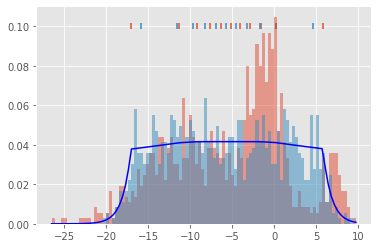

In [6]:
def maxent_pdf(z, R, lams):
    pdf = np.exp(maxent_exponent(R, lams))
    pdf /= np.trapz(pdf, z) # approximate normalisation
    return pdf
def sample_from_pdf(z, pdf, n=1000):
    # rejection sampling to find a sample (to find expectiles:)
    top = pdf.max()
    sample = []
    while len(sample) < n:
        i = np.random.choice(z.size)
        x = np.random.random()*top
        if x < pdf[i]:
            sample.append(z[i])
    return np.array(sample)
    
n = 11
taus = np.linspace(0.01, 0.99, n)
z, R = maxent_exponent_components(taus, SAMPLE)

lams = [1, 0.01, 0.01, 0.001, 0.0001, 0, -0.0001, -0.001, -0.01, -0.01, -1]
pdf = maxent_pdf(z, R, lams)
sample = sample_from_pdf(z, pdf)

# true dist and expectiles
_,bins,_ = plt.hist(SAMPLE, bins=100, density=True, alpha=0.5)
plt.scatter(expectile(SAMPLE, taus),  0.1*np.ones_like(taus), marker="|")

# new dist and expectiles
plt.plot(z, pdf, color="blue")
plt.hist(sample, bins=bins, density=True, alpha=0.5)
plt.scatter(expectile(sample, taus), 0.1*np.ones_like(taus), marker="|")

plt.show()

That's as close as I could get it, and it doesn't look very good...! Also it's weird that a nearly-uniform distribution has very similar expectiles to the highy non-uniform sample we started with...

It should be possible to set the right taus so as so match the original distribution, right? Perhaps playing with asymmetry...

Really, we're trying to get the piecewise linear function in the exponent (including normalisation) to line up with the logarithm of the pdf of the original distribution.

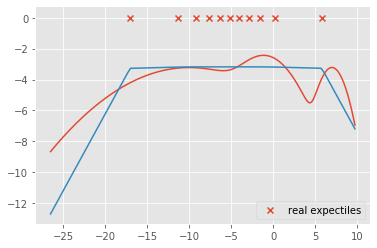

In [9]:

plt.plot(GMM_X, np.log(GMM_Y))
plt.scatter(expectile(SAMPLE, taus) , np.zeros_like(taus), marker="x", label="real expectiles")

lams = [1, 0.01, 0.01, 0.001, 0.0001, 0, -0.0001, -0.001, -0.01, -0.01, -1]
pdf = maxent_pdf(z, R, lams)
plt.plot(z, np.log(pdf))

plt.legend()
plt.show()

OK! The match is actually quite good here... is there a way to nuance it to line up with the kinks in the original?

It will require enough expectiles! Notice that the 'pieces' of the piecewise exponent break at the xpectiles of the original distribution. That means we need expectiles at the points of change of the original distribution if we are going to re-capture the modality in the max-ent imputation. Unfortunately, it seems unlikely that expectiles will end up at these points, since they have such low probability...?